In [1]:
!git clone https://github.com/susannapaoli/multimodal-memes.git

Cloning into 'multimodal-memes'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 456 (delta 112), reused 42 (delta 18), pack-reused 265
Receiving objects: 100% (456/456), 4.27 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.6 MB/s eta 0:00:00


In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import json

sys.path.append('/content/multimodal-memes/DEHATE_BERT')
sys.path.append('/content/multimodal-memes/Utils')
sys.path.append('/content/multimodal-memes/JSON Data')

from dataloader import mydataset 
from plot_curves import plot_loss, plot_acc
from unimodal_trainer import train, validation

'''
For GPT
'''
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Upload data**

In [7]:
%cd /content/multimodal-memes/JSON Data

/content/multimodal-memes/JSON Data


In [ ]:
#with open('train.jsonl', 'r') as f:
    #lines = f.readlines()

#split_idx = int(0.8*len(lines))
#train_lines = lines[:split_idx]
#val_lines = lines[split_idx:]

In [ ]:
#with open('training.json', 'w') as f:
  #for line in lines[:split_idx]:
   # f.write(line)

#with open('validation.json', 'w') as f:
  #for line in lines[split_idx:]:
    #f.write(line)


In [8]:
trainlist = 'train.jsonl'
validlist = 'test_seen.jsonl'

In [9]:
train_dataset = mydataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=16,pin_memory=True)
validation_dataset = mydataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 32, num_workers=16,pin_memory=True)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg

**Model Definition**

In [10]:
model = BertForSequenceClassification.from_pretrained(
    "Hate-speech-CNERG/dehatebert-mono-english", 
    num_labels = 2, #Binary classification
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#model = model.to(device)
model = nn.DataParallel(model).to(device)

**Hyperparameters**

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
num_Epochs = 10
total_steps = len(train_dataloader) * num_Epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,  num_training_steps = total_steps)

In [12]:
modelname = 'BERT_DeHate'
modelpath = './saved_model_checkpoints/'+modelname

In [14]:
writer = SummaryWriter(modelname)

train_loss, v_loss, v_acc = train(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, modelpath, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.5657414050030529
Validation Loss: 0.7481	Validation Accuracy: 0.5970
Epoch:  2
training loss =  0.5116022197823775
Validation Loss: 0.8111	Validation Accuracy: 0.5890
Epoch:  3
training loss =  0.4837501441177569
Validation Loss: 0.8367	Validation Accuracy: 0.5900
Epoch:  4
training loss =  0.4556918834945313
Validation Loss: 0.8343	Validation Accuracy: 0.5970
Epoch:  5
training loss =  0.4371461435816342
Validation Loss: 0.8222	Validation Accuracy: 0.5930
Epoch:  6
training loss =  0.4156165297206183
Validation Loss: 0.8652	Validation Accuracy: 0.5820
Epoch:  7
training loss =  0.39858656281367283
Validation Loss: 0.9319	Validation Accuracy: 0.5930
Epoch:  8
training loss =  0.38044892584806994
Validation Loss: 1.0582	Validation Accuracy: 0.5780
Epoch:  9
training loss =  0.3688347731765948
Validation Loss: 1.0245	Validation Accuracy: 0.5920
Epoch:  10
training loss =  0.35792956579672663
Validation Loss: 1.0456	Validation Accuracy: 0.5860


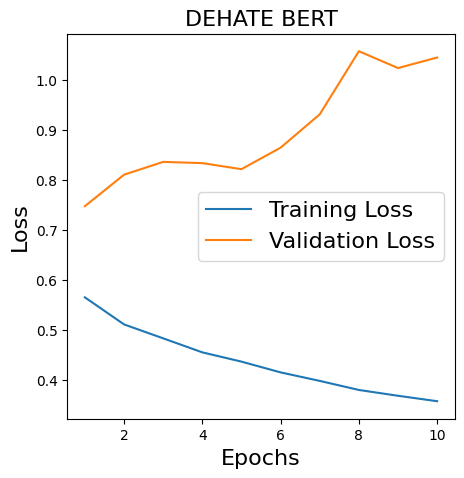

In [15]:
plot_loss(num_Epochs, train_loss, v_loss, 'DEHATE BERT')

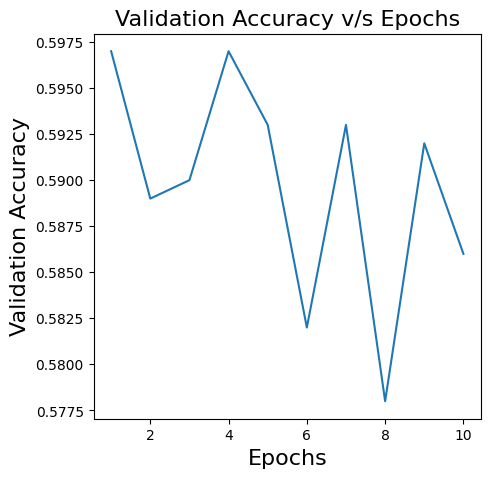

In [16]:
plot_acc(num_Epochs, v_acc)